## Librerias

In [487]:
from google.cloud import bigquery
from time import time
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import zscore
import random

import warnings
warnings.filterwarnings('ignore')

## Parametros

In [5]:
# Datos de las tablas a traer
proyecto = 'co-keralty-costomedico'
dataset = 'Diabetes_avicena_new'

# Nombres de tablas disponibles en el dataset
tables = ['diabetes', 'examenes_por_usuarios','antecedentes_x_usuario','perimetros_x_usuarios','actividadFisica_x_usuarios','diabetes_copy']

client_bq = bigquery.Client(project= proyecto)


tipo_identificacion = {
    'Cédula de ciudadanía' : 0,
    'Tarjeta de identidad' : 1,
    'Cédula de extranjería' : 2,
    'Permiso por Protección Temporal' : 3,
    'Pasaporte' : 4,
    'Permiso Especial de Permanencia' : 5,
    'Salvo Conducto de Permanencia' : 6,
}

nivel_academico = {
    'Básica secundaria' : 0,
    'Básica primaria' : 1,
    'Normalista' : 2,
    'Ninguno' : 3,
    'Profesional' : 4,
    'Técnica profesional' : 5,
    'Preescolar' : 6,
    'Bachillerato técnico' : 7,
    'Media académica o clásica' : 8,
    'Tecnológica' : 9,
    'Maestría' : 10,
    'Especialización' : 11,
    'Doctorado' : 12,
    'None' : 13,
}

raza_paciente = {
    'Otros' : 0,
    'Mestizo' : 1,
    'Raizales' : 2,
    'Afrocolombiano' : 3,
    'Indígena' : 4,
    'Palenquero' : 5,
    'Rom/Gitano' : 6,
    'None' : 7,
}

ejercicio = {
    '20 minutos\n' : 0,
    '40 minutos\n' : 1,
    'Nunca\n' : 2,
    '60 minutos\n' : 3,
}


In [3]:
## Ejemplo consulta

query = f"""SELECT * FROM {proyecto}.{dataset}.{tables[0]}"""

## Funciones

In [55]:
def bring_data_from_bq(table, client_bq, query = '', save = False, read_local = False):

    print(f'Leyendo datos de la tabla: {table}')

    if query == '':
        query = f"""SELECT * FROM {proyecto}.{dataset}.{table} WHERE edad >= 18"""

    if read_local:
        data = pd.read_parquet(f'{table}.parquet')
    else:
        data = client_bq.query(query).result().to_dataframe()

        if save:
            data.to_parquet(f'{table}.parquet')
            print(f'Informacion guardada en el archivo: {table}.parquet')

    return data

def prepare_data(data):
    data_new = data.copy()

    campos = [['tipo_identificacion_paciente',tipo_identificacion],['nivel_academico_paciente',nivel_academico],['raza_paciente',raza_paciente],['hace_ejercicio',ejercicio]]

    for tupla in campos:
        data_new[tupla[0]] = data_new[tupla[0]].replace(tupla[1])

    data_new = data_new.drop(columns=['numero_identificacion_paciente','albuminuria']).astype(float)

    return data_new.drop_duplicates()

## Carga de datos

In [328]:
data_original = bring_data_from_bq(table = tables[0], client_bq = client_bq, save = True, read_local = True)
data = prepare_data(data_original)

Leyendo datos de la tabla: diabetes


In [52]:
data.head()

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.5,25.6,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,0.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.5,25.6,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.5,25.6,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,0.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.5,25.6,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,0.0,0.0


## ¿Cuánta información se encuentra?

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292536 entries, 0 to 292535
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   tipo_identificacion_paciente  292536 non-null  float64
 1   edad                          292536 non-null  float64
 2   genero                        292536 non-null  float64
 3   codigo_ciudad_sucursal        292536 non-null  float64
 4   nivel_academico_paciente      292527 non-null  float64
 5   raza_paciente                 292527 non-null  float64
 6   peso                          292536 non-null  float64
 7   talla                         292536 non-null  float64
 8   imc                           292536 non-null  float64
 9   HDL                           292536 non-null  float64
 10  LDL                           292536 non-null  float64
 11  trigliceridos                 292536 non-null  float64
 12  med_hipertension              292536 non-nul

In [68]:
data_original[data_original.imc >= 700]

,tipo_identificacion_paciente,numero_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,...,LDL,trigliceridos,albuminuria,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
77849,Cédula de ciudadanía,57436121,52,0,47001,Básica secundaria,Otros,70.000000000,0.300000000,777.777777778,...,93.2,66.7,None,0,0,0,0,78.000000000,60 minutos\n,0


In [70]:
data_original[data_original.numero_identificacion_paciente == '57436121']

,tipo_identificacion_paciente,numero_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,...,LDL,trigliceridos,albuminuria,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
77849,Cédula de ciudadanía,57436121,52,0,47001,Básica secundaria,Otros,70.000000000,0.300000000,777.777777778,...,93.2,66.7,None,0,0,0,0,78.000000000,60 minutos\n,0


In [67]:
data[data.imc >= 700]

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
77849,0.0,52.0,0.0,47001.0,0.0,0.0,70.0,0.3,777.777778,44.2,93.2,66.7,0.0,0.0,0.0,0.0,78.0,3.0,0.0


In [57]:
data.describe()

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
count,292536.000000,292536.000000,292536.000000,292536.000000,292527.000000,292527.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000,292536.000000
mean,0.019088,59.097732,0.383037,28903.630087,2.625488,0.175184,73.758353,1.611391,28.331444,48.006205,109.090474,154.455188,0.661638,0.008502,0.733879,0.004266,93.066485,1.395093,0.301529
std,0.216244,15.500512,0.486128,21838.645651,2.746173,0.581321,15.958150,0.094033,5.618801,27.564151,279.267558,478.889615,0.473153,0.091811,0.441929,0.065176,12.994989,0.992946,0.458923
min,0.000000,18.000000,0.000000,5001.000000,0.000000,0.000000,2.870000,0.300000,4.140625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000,0.000000
25%,0.000000,48.000000,0.000000,11001.000000,0.000000,0.000000,63.000000,1.550000,24.807492,39.200000,79.800000,97.400000,0.000000,0.000000,0.000000,0.000000,85.000000,0.000000,0.000000
50%,0.000000,61.000000,0.000000,19001.000000,3.000000,0.000000,72.000000,1.600000,27.717685,46.000000,105.500000,133.000000,1.000000,0.000000,1.000000,0.000000,92.000000,2.000000,0.000000
75%,0.000000,70.000000,1.000000,50001.000000,4.000000,0.000000,82.900000,1.680000,31.170468,54.000000,132.800000,183.000000,1.000000,0.000000,1.000000,0.000000,100.000000,2.000000,1.000000
max,6.000000,107.000000,1.000000,88001.000000,12.000000,6.000000,300.000000,2.060000,777.777778,6708.000000,94167.000000,253000.000000,1.000000,1.000000,1.000000,1.000000,374.000000,3.000000,1.000000


## ¿cuantos datos son nulos?

In [11]:
null_counts = data.isnull().sum()
print("\nDatos nulos por variable:")
print(null_counts)


Datos nulos por variable:
tipo_identificacion_paciente          0
numero_identificacion_paciente        0
edad                                  0
genero                                0
codigo_ciudad_sucursal                0
nivel_academico_paciente              9
raza_paciente                         9
peso                                  0
talla                                 0
imc                                   0
HDL                                   0
LDL                                   0
trigliceridos                         0
albuminuria                       77309
med_hipertension                      0
familiar_dm                           0
ant_cardiovascular                    0
dm_gestacional                        0
PERIMETRO_ABDOMINAL                   0
hace_ejercicio                        0
diabetes                              0
dtype: int64


## ¿Calcular el número de personas con diabetes y sin diabetes?

In [12]:
if 'diabetes' in data.columns:
    personas_con_diabetes = data[data['diabetes'] == True].shape[0]
    personas_sin_diabetes = data[data['diabetes'] == False].shape[0]
    print(f"Personas con diabetes: {personas_con_diabetes}")
    print(f"Personas sin diabetes: {personas_sin_diabetes}")
else:
    raise ValueError("La columna 'diabetes' no existe en el DataFrame")

Personas con diabetes: 88208
Personas sin diabetes: 204328


## Relacion entre las variables

In [14]:
data.columns

Index(['tipo_identificacion_paciente', 'numero_identificacion_paciente',
       'edad', 'genero', 'codigo_ciudad_sucursal', 'nivel_academico_paciente',
       'raza_paciente', 'peso', 'talla', 'imc', 'HDL', 'LDL', 'trigliceridos',
       'albuminuria', 'med_hipertension', 'familiar_dm', 'ant_cardiovascular',
       'dm_gestacional', 'PERIMETRO_ABDOMINAL', 'hace_ejercicio', 'diabetes'],
      dtype='object')

In [15]:
fig = px.scatter(data['edad'],data['peso'])

# fig.show()

Los estadisticos descriptivos para la columna tipo_identificacion_paciente son
Media: 0.019088248967648425
Mediana: 0.0
Moda: 0    0.0
Name: tipo_identificacion_paciente, dtype: float64


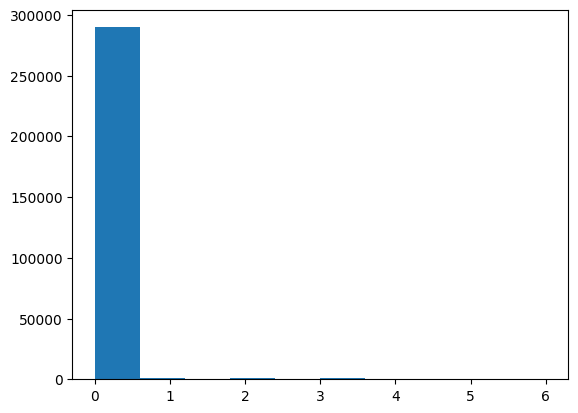

--------------------------------------------------------------
Los estadisticos descriptivos para la columna edad son
Media: 59.09773156124374
Mediana: 61.0
Moda: 0    64.0
Name: edad, dtype: float64


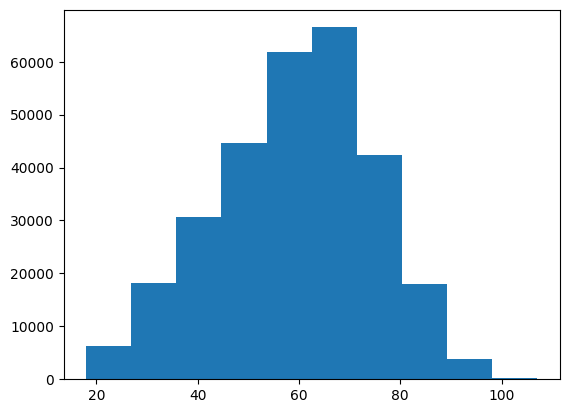

--------------------------------------------------------------
Los estadisticos descriptivos para la columna genero son
Media: 0.38303661771542646
Mediana: 0.0
Moda: 0    0.0
Name: genero, dtype: float64


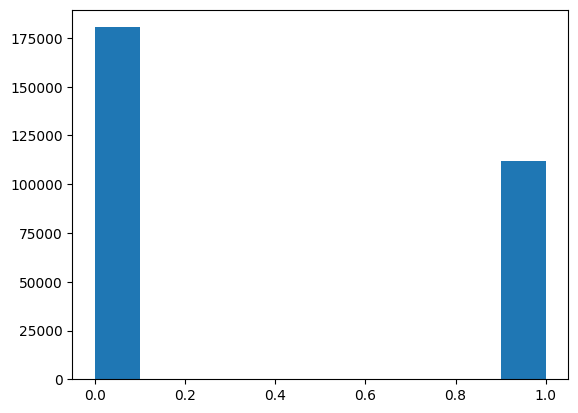

--------------------------------------------------------------
Los estadisticos descriptivos para la columna codigo_ciudad_sucursal son
Media: 28903.63008655345
Mediana: 19001.0
Moda: 0    11001.0
Name: codigo_ciudad_sucursal, dtype: float64


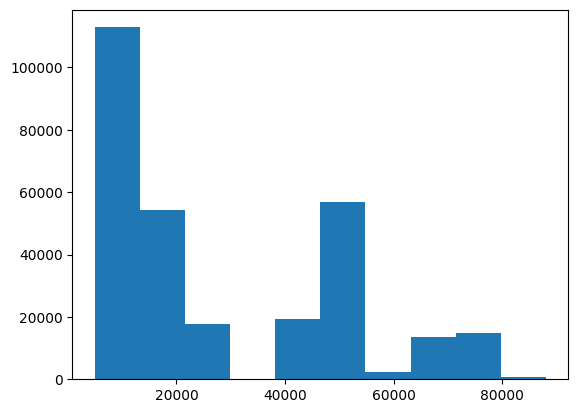

--------------------------------------------------------------
Los estadisticos descriptivos para la columna nivel_academico_paciente son
Media: 2.6254875618318994
Mediana: 3.0
Moda: 0    0.0
Name: nivel_academico_paciente, dtype: float64


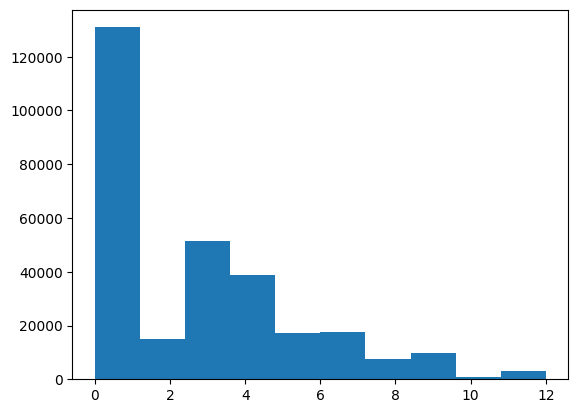

--------------------------------------------------------------
Los estadisticos descriptivos para la columna raza_paciente son
Media: 0.1751838291849983
Mediana: 0.0
Moda: 0    0.0
Name: raza_paciente, dtype: float64


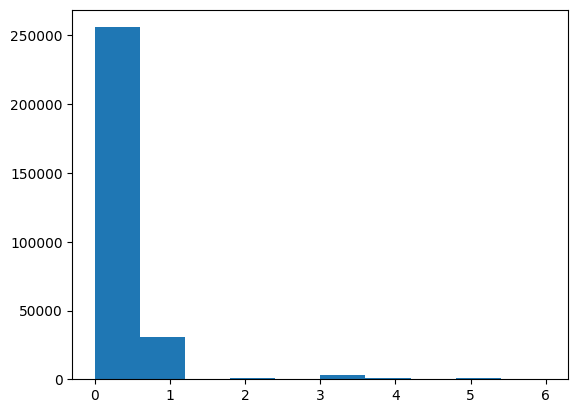

--------------------------------------------------------------
Los estadisticos descriptivos para la columna peso son
Media: 73.75835336505594
Mediana: 72.0
Moda: 0    70.0
Name: peso, dtype: float64


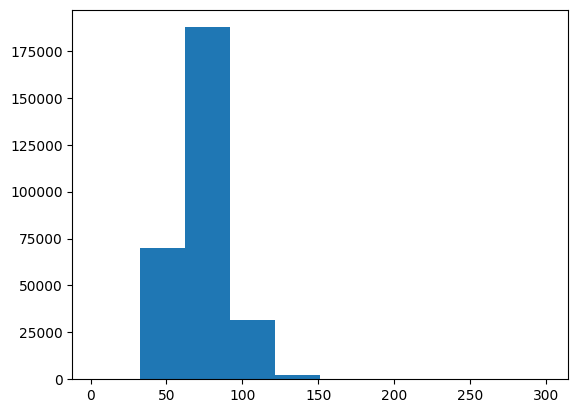

--------------------------------------------------------------
Los estadisticos descriptivos para la columna talla son
Media: 1.6113914663494406
Mediana: 1.6
Moda: 0    1.6
Name: talla, dtype: float64


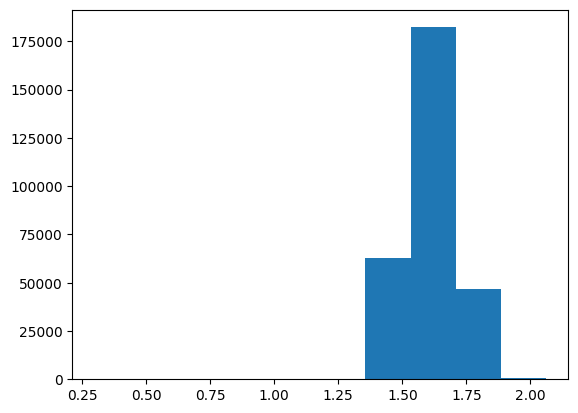

--------------------------------------------------------------
Los estadisticos descriptivos para la columna imc son
Media: 28.3314442169871
Mediana: 27.717685235
Moda: 0    27.34375
Name: imc, dtype: float64


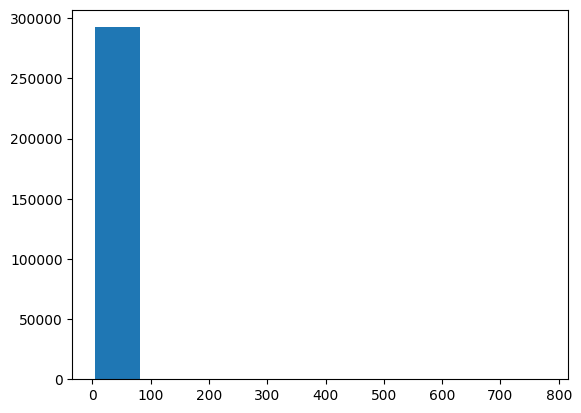

--------------------------------------------------------------
Los estadisticos descriptivos para la columna HDL son
Media: 48.00620532173817
Mediana: 46.0
Moda: 0    45.0
Name: HDL, dtype: float64


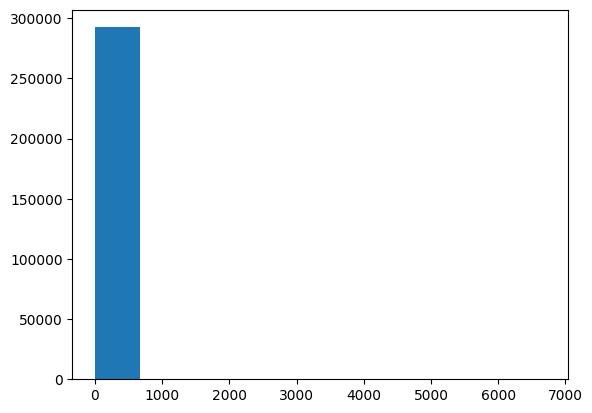

--------------------------------------------------------------
Los estadisticos descriptivos para la columna LDL son
Media: 109.09047402712827
Mediana: 105.5
Moda: 0    100.0
Name: LDL, dtype: float64


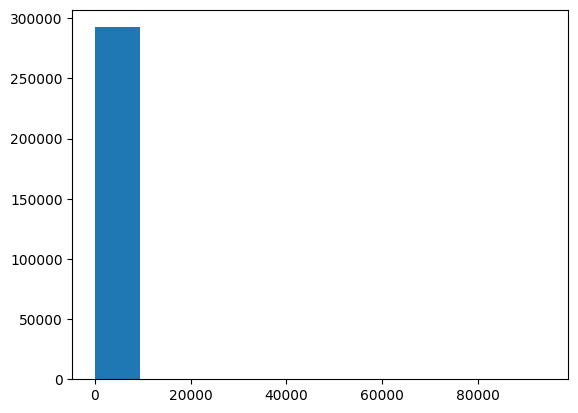

--------------------------------------------------------------
Los estadisticos descriptivos para la columna trigliceridos son
Media: 154.45518760084227
Mediana: 133.0
Moda: 0    110.0
Name: trigliceridos, dtype: float64


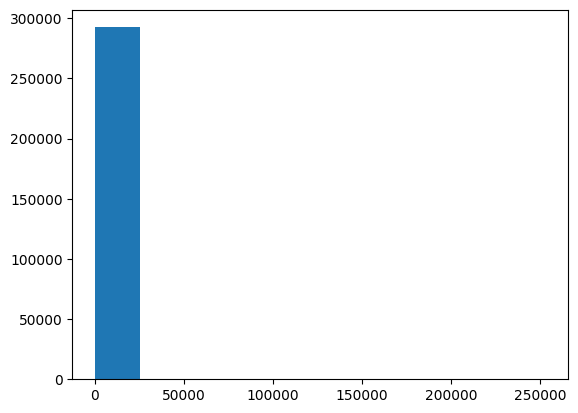

--------------------------------------------------------------
Los estadisticos descriptivos para la columna med_hipertension son
Media: 0.6616382257226461
Mediana: 1.0
Moda: 0    1.0
Name: med_hipertension, dtype: float64


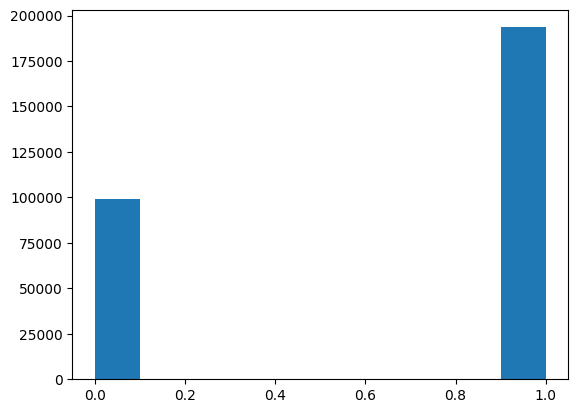

--------------------------------------------------------------
Los estadisticos descriptivos para la columna familiar_dm son
Media: 0.008501517761916481
Mediana: 0.0
Moda: 0    0.0
Name: familiar_dm, dtype: float64


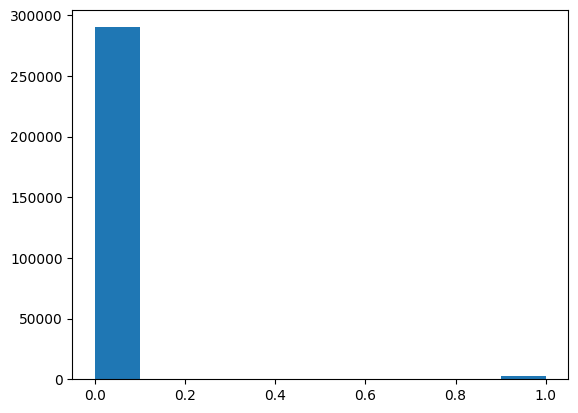

--------------------------------------------------------------
Los estadisticos descriptivos para la columna ant_cardiovascular son
Media: 0.7338789072114201
Mediana: 1.0
Moda: 0    1.0
Name: ant_cardiovascular, dtype: float64


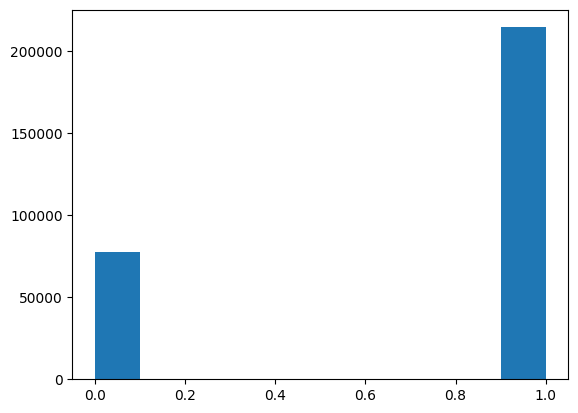

--------------------------------------------------------------
Los estadisticos descriptivos para la columna dm_gestacional son
Media: 0.004266141603084748
Mediana: 0.0
Moda: 0    0.0
Name: dm_gestacional, dtype: float64


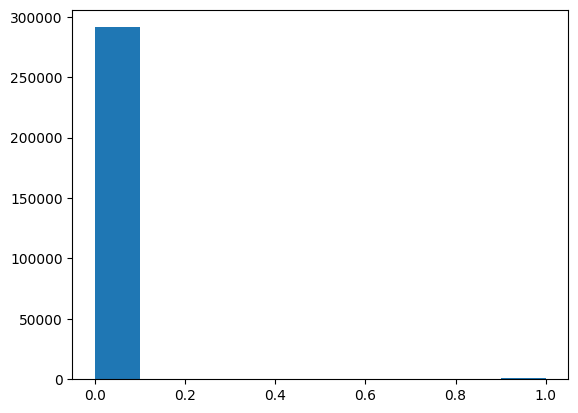

--------------------------------------------------------------
Los estadisticos descriptivos para la columna PERIMETRO_ABDOMINAL son
Media: 93.06648521891323
Mediana: 92.0
Moda: 0    90.0
Name: PERIMETRO_ABDOMINAL, dtype: float64


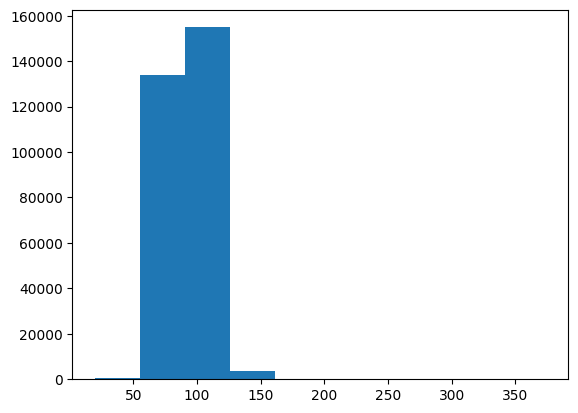

--------------------------------------------------------------
Los estadisticos descriptivos para la columna hace_ejercicio son
Media: 1.3950932534799136
Mediana: 2.0
Moda: 0    2.0
Name: hace_ejercicio, dtype: float64


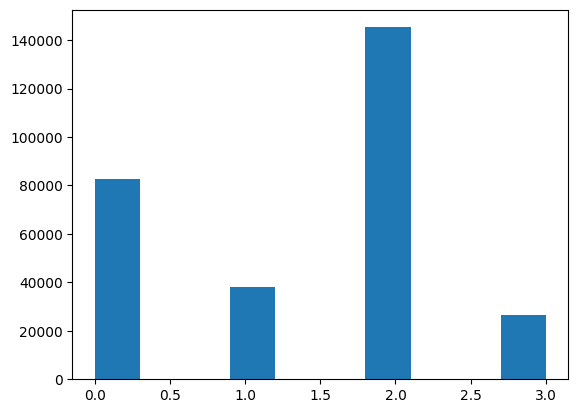

--------------------------------------------------------------
Los estadisticos descriptivos para la columna diabetes son
Media: 0.3015287007411054
Mediana: 0.0
Moda: 0    0.0
Name: diabetes, dtype: float64


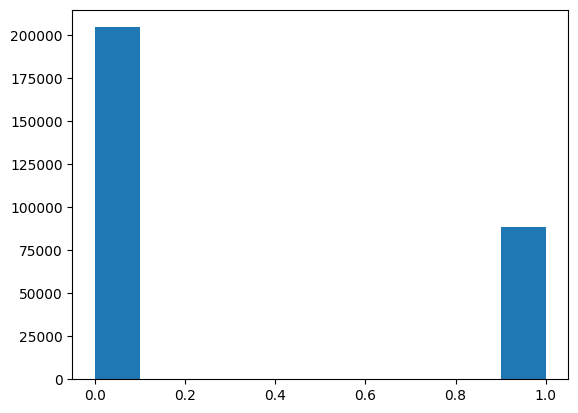

--------------------------------------------------------------


In [125]:
# column = "edad"

for column in data.columns:
    print(f'Los estadisticos descriptivos para la columna {column} son')
    print(f'Media: {data[column].mean()}')
    print(f'Mediana: {data[column].median()}')
    print(f'Moda: {data[column].mode()}')
    plt.hist(data[column])
    plt.show()
    print('--------------------------------------------------------------')

In [ ]:
variables_categoricas = []
variable

In [98]:
data.head(1)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0


In [100]:
variables_categoricas = ['tipo_identificacion_paciente','genero','codigo_ciudad_sucursal','nivel_academico_paciente','raza_paciente','med_hipertension','familiar_dm','ant_cardiovascular','dm_gestacional','hace_ejercicio']

for variable in variables_categoricas:
    print('------------------------------------------------------------------------------------')
    print(f'Resultado de correlacion entre la variable {variable} y diabetes')

    # Tabla de contingencia
    dataset = pd.crosstab(data[variable],data['diabetes'])
    display(dataset)

    # Calculo de Chi-cuadrado
    X2 = stats.chi2_contingency(dataset, correction=False)[0]
    print(f'El estadistico Chi-cuadrado es: {X2}')

    # Sumar el Arreglo
    N = np.sum(np.array(dataset)) 
    print(f'La suma de las frecuencias es: {N}')

    # Encontrar el minimo entre la cantidad de filas y columnas
    minimum_dimension = min(dataset.shape)-1
    print(f'La dimension usada es: {minimum_dimension}')

    # Calculo del coeficiente de Cramer
    result = np.sqrt((X2/N) / minimum_dimension) 
    print(f'El coeficiente de Cramer es: {result}')

------------------------------------------------------------------------------------
Resultado de correlacion entre la variable tipo_identificacion_paciente y diabetes


diabetes,0.0,1.0
tipo_identificacion_paciente,,
0.0,202340,87527
1.0,614,99
2.0,734,413
3.0,595,139
4.0,2,0
5.0,42,29
6.0,1,1


El estadistico Chi-cuadrado es: 157.43842870546771
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.023198810318204647
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable genero y diabetes


diabetes,0.0,1.0
genero,,
0.0,129989,50495
1.0,74339,37713


El estadistico Chi-cuadrado es: 1058.6875943200519
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.06015811958166036
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable codigo_ciudad_sucursal y diabetes


diabetes,0.0,1.0
codigo_ciudad_sucursal,,
5001.0,9736,3713
5088.0,6,2
5266.0,47,21
5360.0,3,2
5615.0,1056,82
...,...,...
76834.0,36,4
76892.0,319,95
81001.0,119,53


El estadistico Chi-cuadrado es: 5199.444621638104
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.13331800897505092
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable nivel_academico_paciente y diabetes


diabetes,0.0,1.0
nivel_academico_paciente,,
0.0,72097,32417
1.0,17326,9102
2.0,10070,4894
3.0,35264,16211
4.0,28768,10019
5.0,12887,4470
6.0,684,320
7.0,11947,4691
8.0,5020,2630


El estadistico Chi-cuadrado es: 1148.6261801945375
La suma de las frecuencias es: 292527
La dimension usada es: 1
El coeficiente de Cramer es: 0.06266230652995282
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable raza_paciente y diabetes


diabetes,0.0,1.0
raza_paciente,,
0.0,177068,78843
1.0,23186,7505
2.0,366,201
3.0,2237,1041
4.0,824,333
5.0,418,161
6.0,221,123


El estadistico Chi-cuadrado es: 544.8683616097179
La suma de las frecuencias es: 292527
La dimension usada es: 1
El coeficiente de Cramer es: 0.04315814966807833
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable med_hipertension y diabetes


diabetes,0.0,1.0
med_hipertension,,
0.0,74180,24803
1.0,130148,63405


El estadistico Chi-cuadrado es: 1843.9817154384393
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.07939417601779414
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable familiar_dm y diabetes


diabetes,0.0,1.0
familiar_dm,,
0.0,202427,87622
1.0,1901,586


El estadistico Chi-cuadrado es: 51.72765643771048
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.013297553369254289
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable ant_cardiovascular y diabetes


diabetes,0.0,1.0
ant_cardiovascular,,
0.0,63876,13974
1.0,140452,74234


El estadistico Chi-cuadrado es: 7500.458656405474
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.16012319655179624
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable dm_gestacional y diabetes


diabetes,0.0,1.0
dm_gestacional,,
0.0,204328,86960
1.0,0,1248


El estadistico Chi-cuadrado es: 2903.295355771174
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.09962215919162622
------------------------------------------------------------------------------------
Resultado de correlacion entre la variable hace_ejercicio y diabetes


diabetes,0.0,1.0
hace_ejercicio,,
0.0,56875,25874
1.0,25888,12076
2.0,102898,42420
3.0,18667,7838


El estadistico Chi-cuadrado es: 166.37465549850407
La suma de las frecuencias es: 292536
La dimension usada es: 1
El coeficiente de Cramer es: 0.02384810774895942


In [114]:
variables_numericas = [column for column in data.columns if column not in variables_categoricas]
# variables_numericas.remove('diabetes')
variables_numericas

['edad',
 'peso',
 'talla',
 'imc',
 'HDL',
 'LDL',
 'trigliceridos',
 'PERIMETRO_ABDOMINAL',
 'diabetes']

In [122]:
px.imshow(data[variables_numericas].corr(method = 'pearson'))

In [123]:
px.imshow(data[variables_numericas].corr(method = 'kendall'))

In [124]:
px.imshow(data[variables_numericas].corr(method = 'spearman'))

## Clusters

In [297]:
data

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.50,25.600000,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0
1,0.0,54.0,0.0,54001.0,1.0,0.0,57.6,1.50,25.600000,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,0.0,0.0
2,0.0,69.0,0.0,15001.0,2.0,0.0,57.6,1.50,25.600000,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,0.0
3,0.0,57.0,0.0,8001.0,3.0,0.0,57.6,1.50,25.600000,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,0.0,1.0
4,0.0,50.0,0.0,19001.0,4.0,0.0,57.6,1.50,25.600000,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,0.0,86.0,0.0,11001.0,0.0,0.0,68.5,1.42,33.971434,33.4,98.32,107.07,1.0,0.0,1.0,0.0,95.0,2.0,0.0
292532,0.0,71.0,0.0,68001.0,1.0,0.0,68.5,1.42,33.971434,30.3,191.90,201.00,1.0,0.0,1.0,0.0,100.0,1.0,1.0
292533,0.0,71.0,0.0,68001.0,1.0,0.0,68.5,1.42,33.971434,30.3,191.90,201.00,1.0,0.0,1.0,0.0,100.0,0.0,1.0
292534,0.0,64.0,0.0,11001.0,8.0,0.0,68.9,1.49,31.034638,71.6,135.00,98.00,1.0,0.0,1.0,0.0,103.0,2.0,0.0


In [187]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.preprocessing import StandardScaler

In [528]:
def normalize_data(data, variable):
    data_prueba = data[[variable]]

    data_prueba['zscore'] = np.abs(zscore(data_prueba[variable]))
    data_prueba.loc[data_prueba.zscore >= 3,'zscore'] = 'Outlayer'

    data_prueba = data_prueba[data_prueba != 'Outlayer']
    data_prueba.drop(columns = ['zscore'], inplace=True)

    scaler = StandardScaler()
    datos_normalizados = scaler.fit_transform(np.array(data_prueba))

    return datos_normalizados

def elbow_process(datos_normalizados, plot = False):
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(1, 10)

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(datos_normalizados)
        kmeanModel.fit(datos_normalizados)
    
        distortions.append(sum(np.min(cdist(datos_normalizados, kmeanModel.cluster_centers_,
                                            'euclidean'), axis=1)) / datos_normalizados.shape[0])
        inertias.append(kmeanModel.inertia_)
    
        mapping1[k] = sum(np.min(cdist(datos_normalizados, kmeanModel.cluster_centers_,
                                    'euclidean'), axis=1)) / datos_normalizados.shape[0]
        mapping2[k] = kmeanModel.inertia_

    if plot:
        # for key, val in mapping1.items():
        #     print(f'{key} : {val}')

        plt.plot(K, distortions, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Distortion')
        plt.title('The Elbow Method using Distortion')
        plt.show()

        # for key, val in mapping2.items():
        #     print(f'{key} : {val}')


        plt.plot(K, inertias, 'bx-')
        plt.xlabel('Values of K')
        plt.ylabel('Inertia')
        plt.title('The Elbow Method using Inertia')
        plt.show()

def train_kmeans(data, clusters):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=42, n_init=10)

    kmeans.fit(data) 

    return kmeans

def etiquetar_clusters(data,variable, model, plot = False):

    data_label = data#[[variable]].copy()
    
    cluster_name ='cluster_'+ variable
    data_label[cluster_name] = kmeans.predict(data_label[[variable]])

    if plot:
        # Visualizar la variable 'recency' en función de los clusters
        sns.boxplot(data=data_label, x=cluster_name, y=variable)
        plt.title(f'{variable.upper()} por Clusters CENTROIDE (kmeans)')
        plt.xlabel('Cluster')
        plt.ylabel(variable)
        plt.show()

    return data_label


In [295]:
data.head(1)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,cluster_HDL
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0,3


------------------------------------------------------------------------
Procesando la variable: edad
------------------------------------------------------------------------


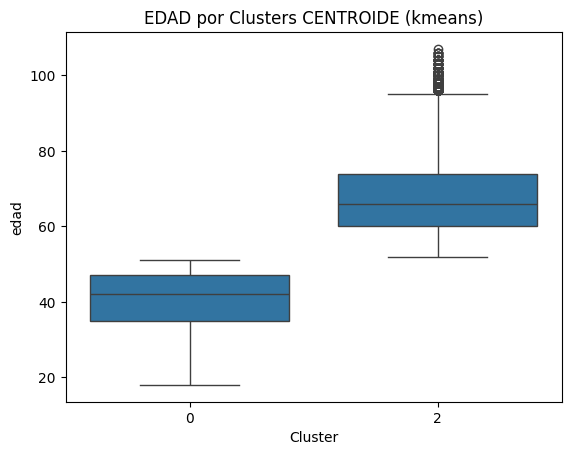

------------------------------------------------------------------------
Procesando la variable: imc
------------------------------------------------------------------------


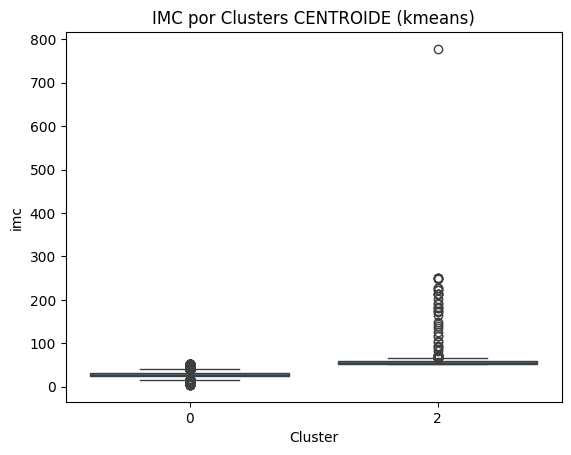

------------------------------------------------------------------------
Procesando la variable: HDL
------------------------------------------------------------------------


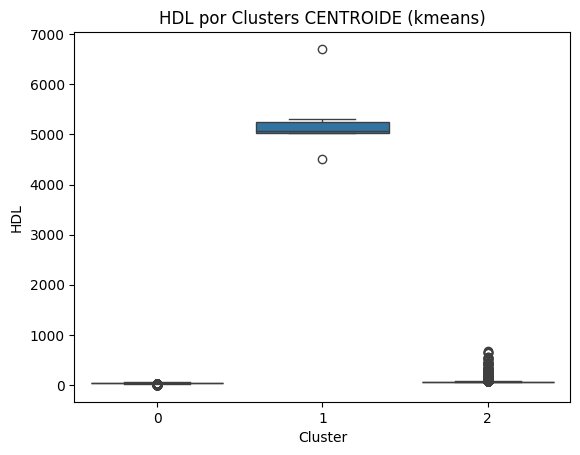

------------------------------------------------------------------------
Procesando la variable: LDL
------------------------------------------------------------------------


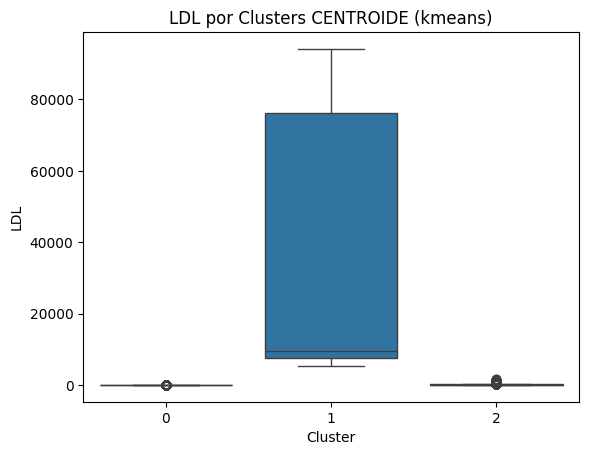

------------------------------------------------------------------------
Procesando la variable: trigliceridos
------------------------------------------------------------------------


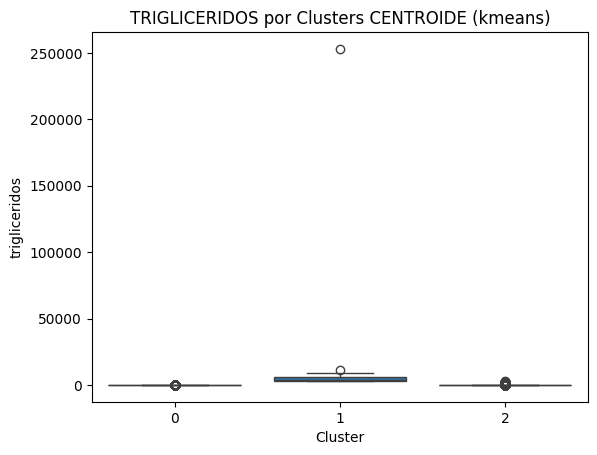

------------------------------------------------------------------------
Procesando la variable: PERIMETRO_ABDOMINAL
------------------------------------------------------------------------


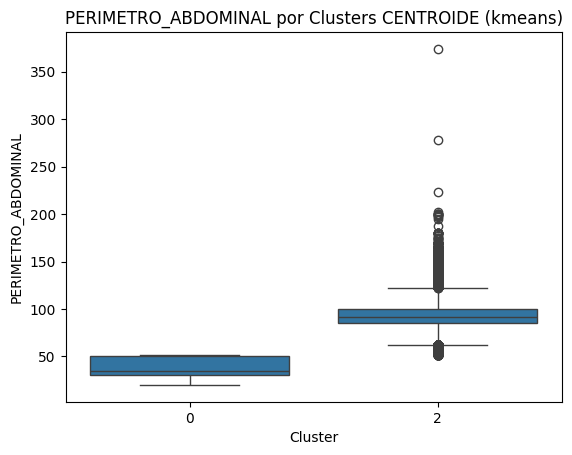

In [529]:
variables_to_iterar = ['edad',
                    #    'codigo_ciudad_sucursal',
                       'imc',
                       'HDL',
                       'LDL',
                       'trigliceridos',
                       'PERIMETRO_ABDOMINAL']

elbow = False

clusters_variables = {
    'edad': 3,
    # 'codigo_ciudad_sucursal': 3,
    'imc': 5,
    'HDL': 3,
    'LDL': 2,
    'trigliceridos': 2,
    'PERIMETRO_ABDOMINAL': 4,
}

data_full = data.copy()

for variable in variables_to_iterar:
    print('------------------------------------------------------------------------')
    print(f'Procesando la variable: {variable}')
    print('------------------------------------------------------------------------')

    datos_normalizados = normalize_data(data = data,variable = variable)
    
    if elbow:
        elbow_process(datos_normalizados=datos_normalizados , plot=True)

    model = train_kmeans(data = datos_normalizados, clusters = clusters_variables[variable])

    df_final = etiquetar_clusters(data = data_full,variable = variable, model = model, plot = True)
    

## Prediccion

In [534]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

In [425]:
data.head(1)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,64.0,0.0,11001.0,0.0,0.0,57.6,1.5,25.6,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0


In [426]:
variables_to_train = ['edad',
                      'genero',
                    #   'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

df_to_train = df_final[variables_to_train].copy()
df_to_train = data[variables_to_train].copy()
df_to_train

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente,diabetes
0,64.0,0.0,25.600000,58.0,87.43,60.64,0.0,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0
1,54.0,0.0,25.600000,57.0,30.00,374.00,0.0,0.0,0.0,0.0,75.0,0.0,1.0,0.0,0.0
2,69.0,0.0,25.600000,66.0,171.00,91.00,0.0,0.0,0.0,0.0,89.0,1.0,2.0,0.0,0.0
3,57.0,0.0,25.600000,39.0,143.00,280.00,0.0,0.0,0.0,0.0,95.0,0.0,3.0,0.0,1.0
4,50.0,0.0,25.600000,59.0,140.00,186.00,0.0,0.0,0.0,0.0,87.0,0.0,4.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,86.0,0.0,33.971434,33.4,98.32,107.07,1.0,0.0,1.0,0.0,95.0,2.0,0.0,0.0,0.0
292532,71.0,0.0,33.971434,30.3,191.90,201.00,1.0,0.0,1.0,0.0,100.0,1.0,1.0,0.0,1.0
292533,71.0,0.0,33.971434,30.3,191.90,201.00,1.0,0.0,1.0,0.0,100.0,0.0,1.0,0.0,1.0
292534,64.0,0.0,31.034638,71.6,135.00,98.00,1.0,0.0,1.0,0.0,103.0,2.0,8.0,0.0,0.0


In [433]:
df_to_train.nivel_academico_paciente.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       nan])

In [434]:
df_to_train.raza_paciente.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6., nan])

In [427]:
X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

0         0.0
1         0.0
2         0.0
3         1.0
4         0.0
         ... 
292531    0.0
292532    1.0
292533    1.0
292534    0.0
292535    1.0
Name: diabetes, Length: 292536, dtype: float64

In [428]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [429]:
lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [416]:
lineal_model.score(X_test,y_test)

-0.06785719897878106

In [417]:
y_test

230468    0.0
241484    1.0
271015    0.0
114476    0.0
144750    1.0
         ... 
235984    0.0
5982      1.0
35827     0.0
153384    0.0
191307    0.0
Name: diabetes, Length: 96537, dtype: float64

In [418]:
X_test

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
230468,88.0,1.0,19.100092,54.00,106.00,71.00,1.0,0.0,1.0,0.0,82.0,2.0
241484,75.0,0.0,28.407877,53.20,126.00,160.00,1.0,0.0,1.0,0.0,88.0,2.0
271015,64.0,0.0,31.555556,37.00,137.40,323.00,1.0,0.0,1.0,0.0,102.0,2.0
114476,88.0,0.0,24.209105,50.80,120.60,173.00,1.0,0.0,1.0,0.0,80.0,0.0
144750,45.0,1.0,31.884502,29.90,47.00,255.20,0.0,0.0,1.0,0.0,112.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
235984,94.0,1.0,24.456063,29.33,93.08,131.96,1.0,0.0,1.0,0.0,97.0,2.0
5982,70.0,0.0,21.936347,41.50,173.80,255.10,0.0,0.0,0.0,0.0,89.0,2.0
35827,41.0,1.0,36.794821,45.40,109.40,233.00,0.0,0.0,0.0,0.0,82.0,0.0
153384,64.0,1.0,28.471124,51.00,82.20,89.00,1.0,0.0,1.0,0.0,92.0,1.0


In [419]:
y_test.iloc[[-4]]

5982    1.0
Name: diabetes, dtype: float64

In [420]:
index = X_test.iloc[[-4]].index

X_test.iloc[[-4]]

,edad,genero,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio
5982,70.0,0.0,21.936347,41.5,173.8,255.1,0.0,0.0,0.0,0.0,89.0,2.0


In [421]:
data.loc[index]

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
5982,0.0,70.0,0.0,15001.0,3.0,0.0,59.0,1.64,21.936347,41.5,173.8,255.1,0.0,0.0,0.0,0.0,89.0,2.0,1.0


In [422]:
lineal_model.predict(X_test.iloc[[-4]])

array([0.32926545])

In [423]:
ejercicio

{'20 minutos\n': 0, '40 minutos\n': 1, 'Nunca\n': 2, '60 minutos\n': 3}

In [424]:
lineal_model.score(X_test,y_test)

-0.06785719897878106

In [449]:
ejercicio

{'20 minutos\n': 0, '40 minutos\n': 1, 'Nunca\n': 2, '60 minutos\n': 3}

In [456]:
## Pesos Manuales

def peso_edad(value):
    if value < 45:
        return 0
    elif value < 54:
        return 1
    elif value <= 64:
        return 2
    else:
        return 3

def peso_imc(value):
    if value < 30:
        return 0
    elif value < 35:
        return 1
    elif value < 40:
        return 2
    else:
        return 3

def peso_pa(value, gender):

    if gender == 0:
        if value < 90:
            return 0
        elif value < 95:
            return 1
        else:
            return 2
    else:
        if value < 94:
            return 0
        elif value < 100:
            return 1
        else:
            return 2

def peso_ejercicio(value):
    if value == 2:
        return 2
    else:
        return 0

def peso_var_bivalente(value):
    if value == 1:
        return 2
    else:
        return 0

def peso_HDL(value):
    if value < 40:
        return 2
    elif value < 60:
        return 1
    else:
        return 0

def peso_LDL(value):
    if value < 130:
        return 0
    elif value < 160:
        return 1
    elif value < 190:
        return 2
    else:
        return 3

def peso_trigliceridos(value):
    if value < 150:
        return 0
    elif value < 200:
        return 1
    elif value < 500:
        return 2
    else:
        return 3


In [482]:
genero = 1
data_prueba = data[data.genero == genero].copy()

In [508]:
dict_variables = {
    'edad' : peso_edad,
    'imc' : peso_imc,
    'PERIMETRO_ABDOMINAL' : peso_pa,
    'hace_ejercicio' : peso_ejercicio,
    'med_hipertension' : peso_var_bivalente,
    'familiar_dm' : peso_var_bivalente,
    'HDL' : peso_HDL,
    'LDL' : peso_LDL,
    'trigliceridos' : peso_trigliceridos,
    'ant_cardiovascular' : peso_var_bivalente,
    'dm_gestacional' : peso_var_bivalente,
}

list(dict_variables.keys())

['edad',
 'imc',
 'PERIMETRO_ABDOMINAL',
 'hace_ejercicio',
 'med_hipertension',
 'familiar_dm',
 'HDL',
 'LDL',
 'trigliceridos',
 'ant_cardiovascular',
 'dm_gestacional']

In [484]:
for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()

data_prueba

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
6,0.0,1,1.0,41001.0,0.0,0.0,101.0,1.68,2,2,1,2,0,0,0,0,2,2,0.0
7,0.0,0,1.0,19001.0,0.0,1.0,101.0,1.68,2,1,0,0,0,0,0,0,2,2,0.0
24,1.0,0,1.0,20001.0,1.0,0.0,51.0,1.64,0,1,0,0,0,0,0,0,0,2,0.0
25,0.0,3,1.0,8758.0,3.0,0.0,83.3,1.75,0,1,0,1,0,0,0,0,1,0,0.0
105,0.0,1,1.0,19001.0,0.0,0.0,88.2,1.75,0,2,0,0,0,0,0,0,2,2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.0,2,1.0,11001.0,2.0,0.0,94.6,1.73,1,1,0,2,2,0,2,0,2,2,0.0
292524,0.0,1,1.0,5001.0,0.0,0.0,94.6,1.73,1,1,2,2,2,0,2,0,2,0,0.0
292525,0.0,3,1.0,25307.0,3.0,0.0,94.6,1.73,1,1,0,0,2,0,2,0,2,2,1.0
292527,0.0,2,1.0,8001.0,5.0,0.0,99.1,1.81,1,1,0,0,2,0,2,0,1,0,0.0


In [480]:
data_prueba.dropna()

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
0,0.0,2,0.0,11001.0,0.0,0.0,57.6,1.50,0,1,0,0,0,0,0,0,0,0,0.0
1,0.0,2,0.0,54001.0,1.0,0.0,57.6,1.50,0,1,0,2,0,0,0,0,0,0,0.0
2,0.0,3,0.0,15001.0,2.0,0.0,57.6,1.50,0,0,2,0,0,0,0,0,0,0,0.0
3,0.0,2,0.0,8001.0,3.0,0.0,57.6,1.50,0,2,1,2,0,0,0,0,2,0,1.0
4,0.0,1,0.0,19001.0,4.0,0.0,57.6,1.50,0,1,1,1,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292531,0.0,3,0.0,11001.0,0.0,0.0,68.5,1.42,1,2,0,0,2,0,2,0,2,2,0.0
292532,0.0,3,0.0,68001.0,1.0,0.0,68.5,1.42,1,2,3,2,2,0,2,0,2,0,1.0
292533,0.0,3,0.0,68001.0,1.0,0.0,68.5,1.42,1,2,3,2,2,0,2,0,2,0,1.0
292534,0.0,2,0.0,11001.0,8.0,0.0,68.9,1.49,1,0,1,0,2,0,2,0,2,2,0.0


In [539]:
df = data[data.diabetes == 1]
sample = data[data.diabetes == 0].sample(len(df))

df = pd.concat([df,sample])
df

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
3,0.00,57.00,0.00,8001.00,3.00,0.00,57.60,1.50,25.60,39.00,143.00,280.00,0.00,0.00,0.00,0.00,95.00,0.00,1.00
11,0.00,43.00,0.00,50001.00,0.00,0.00,101.00,1.68,35.79,44.92,121.00,321.00,0.00,0.00,0.00,1.00,126.00,2.00,1.00
21,0.00,32.00,0.00,11001.00,3.00,0.00,51.00,1.64,18.96,81.00,83.00,34.00,0.00,0.00,0.00,1.00,74.00,0.00,1.00
26,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,2.00,1.00
31,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46554,0.00,50.00,0.00,8001.00,7.00,0.00,66.20,1.60,25.86,57.00,119.00,89.00,0.00,0.00,0.00,0.00,85.00,0.00,0.00
252766,0.00,82.00,1.00,8758.00,5.00,0.00,58.00,1.61,22.38,48.00,65.00,85.00,1.00,0.00,1.00,0.00,94.00,1.00,0.00
171737,0.00,49.00,0.00,8001.00,3.00,0.00,79.00,1.52,34.19,42.40,122.40,138.00,1.00,0.00,1.00,0.00,70.00,1.00,0.00
26433,0.00,48.00,0.00,54001.00,7.00,0.00,61.50,1.56,25.27,53.00,55.00,69.00,0.00,0.00,0.00,0.00,80.00,2.00,0.00


In [540]:
genero = 0
data_prueba = df[df.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                      'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

lineal_model.score(X_test,y_test)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
3,0.00,2,0.00,8001.00,3.00,0.00,57.60,1.50,0,2,1,2,0,0,0,0,2,0,1.00,9
11,0.00,0,0.00,50001.00,0.00,0.00,101.00,1.68,2,1,0,2,0,0,0,2,2,2,1.00,11
21,0.00,0,0.00,11001.00,3.00,0.00,51.00,1.64,0,0,0,0,0,0,0,2,0,0,1.00,2
26,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,2,1.00,3
31,0.00,0,0.00,20001.00,4.00,0.00,61.20,1.50,0,1,0,0,0,0,0,0,0,0,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136829,0.00,2,0.00,8001.00,7.00,0.00,80.50,1.52,1,1,0,0,2,0,2,0,2,0,0.00,10
46554,0.00,1,0.00,8001.00,7.00,0.00,66.20,1.60,0,1,0,0,0,0,0,0,0,0,0.00,2
171737,0.00,1,0.00,8001.00,3.00,0.00,79.00,1.52,1,1,0,0,2,0,2,0,0,0,0.00,7
26433,0.00,1,0.00,54001.00,7.00,0.00,61.50,1.56,0,1,0,0,0,0,0,0,0,2,0.00,4


0.1454277957786787

In [541]:
data_prueba.diabetes_peso.max()

20

In [542]:
for i in range(4):
    print('--------------------------------------------------------')
    valor = random.randint(0,len(X_test))

    index = X_test.iloc[[valor]].index

    display(X_test.iloc[[valor]])

    display(data_prueba.loc[index])

    print(lineal_model.predict(X_test.iloc[[valor]])/data_prueba.diabetes_peso.max())

--------------------------------------------------------


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
23930,1,0.00,5615.00,0,2,0,0,0,0,0,0,0,0,7.00,0.00


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
23930,0.00,1,0.00,5615.00,7.00,0.00,68.30,1.60,0,2,0,0,0,0,0,0,0,0,0.00,3


[0.01393643]
--------------------------------------------------------


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
127281,3,0.00,54001.00,1,1,0,0,2,0,2,0,1,0,0.00,0.00


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
127281,0.00,3,0.00,54001.00,0.00,0.00,74.00,1.50,1,1,0,0,2,0,2,0,1,0,1.00,10


[0.03181797]
--------------------------------------------------------


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
90390,3,0.00,8001.00,3,1,0,0,2,0,2,0,2,2,0.00,0.00


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
90390,0.00,3,0.00,8001.00,0.00,0.00,113.20,1.65,3,1,0,0,2,0,2,0,2,2,0.00,15


[0.03469119]
--------------------------------------------------------


,edad,genero,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
56937,0,0.00,8001.00,3,2,0,0,0,0,0,0,2,2,0.00,0.00


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
56937,0.00,0,0.00,8001.00,0.00,0.00,113.50,1.67,3,2,0,0,0,0,0,0,2,2,0.00,9


[0.01765099]


In [527]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

lineal_model = LinearRegression()

lineal_model.fit(X_train,y_train)

lineal_model.score(X_test,y_test)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.0,1,1.0,41001.0,0.0,0.0,101.0,1.68,2,2,1,2,0,0,0,0,2,2,0.0,12
7,0.0,0,1.0,19001.0,0.0,1.0,101.0,1.68,2,1,0,0,0,0,0,0,2,2,0.0,7
24,1.0,0,1.0,20001.0,1.0,0.0,51.0,1.64,0,1,0,0,0,0,0,0,0,2,0.0,3
25,0.0,3,1.0,8758.0,3.0,0.0,83.3,1.75,0,1,0,1,0,0,0,0,1,0,0.0,6
105,0.0,1,1.0,19001.0,0.0,0.0,88.2,1.75,0,2,0,0,0,0,0,0,2,2,0.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.0,2,1.0,11001.0,2.0,0.0,94.6,1.73,1,1,0,2,2,0,2,0,2,2,0.0,14
292524,0.0,1,1.0,5001.0,0.0,0.0,94.6,1.73,1,1,2,2,2,0,2,0,2,0,0.0,13
292525,0.0,3,1.0,25307.0,3.0,0.0,94.6,1.73,1,1,0,0,2,0,2,0,2,2,1.0,13
292527,0.0,2,1.0,8001.0,5.0,0.0,99.1,1.81,1,1,0,0,2,0,2,0,1,0,0.0,9


0.07310034744515681

In [543]:
genero = 1
data_prueba = df[df.genero == genero].copy()

display(df)

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes
3,0.00,57.00,0.00,8001.00,3.00,0.00,57.60,1.50,25.60,39.00,143.00,280.00,0.00,0.00,0.00,0.00,95.00,0.00,1.00
11,0.00,43.00,0.00,50001.00,0.00,0.00,101.00,1.68,35.79,44.92,121.00,321.00,0.00,0.00,0.00,1.00,126.00,2.00,1.00
21,0.00,32.00,0.00,11001.00,3.00,0.00,51.00,1.64,18.96,81.00,83.00,34.00,0.00,0.00,0.00,1.00,74.00,0.00,1.00
26,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,2.00,1.00
31,0.00,40.00,0.00,20001.00,4.00,0.00,61.20,1.50,27.20,51.00,125.00,87.00,0.00,0.00,0.00,0.00,70.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46554,0.00,50.00,0.00,8001.00,7.00,0.00,66.20,1.60,25.86,57.00,119.00,89.00,0.00,0.00,0.00,0.00,85.00,0.00,0.00
252766,0.00,82.00,1.00,8758.00,5.00,0.00,58.00,1.61,22.38,48.00,65.00,85.00,1.00,0.00,1.00,0.00,94.00,1.00,0.00
171737,0.00,49.00,0.00,8001.00,3.00,0.00,79.00,1.52,34.19,42.40,122.40,138.00,1.00,0.00,1.00,0.00,70.00,1.00,0.00
26433,0.00,48.00,0.00,54001.00,7.00,0.00,61.50,1.56,25.27,53.00,55.00,69.00,0.00,0.00,0.00,0.00,80.00,2.00,0.00


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
121,0.00,0,1.00,5001.00,0.00,0.00,82.00,1.88,0,1,0,0,0,0,0,0,0,0,1.00,1
128,0.00,1,1.00,25258.00,2.00,0.00,52.00,1.51,0,0,0,1,0,0,0,0,0,0,1.00,2
167,2.00,2,1.00,5001.00,4.00,0.00,98.00,1.75,1,1,1,1,0,0,0,0,2,2,1.00,10
168,0.00,3,1.00,50001.00,2.00,0.00,98.00,1.75,1,1,2,0,0,0,0,0,2,2,1.00,11
172,0.00,2,1.00,41001.00,0.00,0.00,98.00,1.75,1,2,0,2,0,0,0,0,2,2,1.00,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132489,0.00,3,1.00,54001.00,0.00,0.00,54.00,1.59,0,2,0,0,2,0,2,0,0,0,0.00,9
152457,0.00,3,1.00,50001.00,0.00,0.00,77.00,1.69,0,1,0,0,2,0,2,0,1,0,0.00,9
61271,0.00,0,1.00,8001.00,0.00,0.00,58.00,1.63,0,1,2,1,0,2,0,0,0,2,0.00,8
48624,0.00,3,1.00,15001.00,0.00,0.00,80.00,1.74,0,2,0,0,0,0,0,0,1,2,0.00,8


 21%|██▏       | 9/42 [00:14<01:45,  3.20s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 26%|██▌       | 11/42 [01:03<06:41, 12.94s/it]

GaussianProcessRegressor model failed to execute
Unable to allocate 8.14 GiB for an array with shape (1092898128,) and data type float64


 38%|███▊      | 16/42 [07:30<47:23, 109.38s/it]

KernelRidge model failed to execute
Unable to allocate 16.3 GiB for an array with shape (46753, 46753) and data type float64


 98%|█████████▊| 41/42 [1:37:38<00:49, 49.52s/it]    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 46753, number of used features: 13
[LightGBM] [Info] Start training from score 0.539602


100%|██████████| 42/42 [1:37:38<00:00, 139.49s/it]

                                       Adjusted R-Squared  \
Model                                                       
LGBMRegressor                                        0.12   
HistGradientBoostingRegressor                        0.12   
XGBRegressor                                         0.11   
GradientBoostingRegressor                            0.11   
ElasticNetCV                                         0.08   
LassoCV                                              0.08   
BayesianRidge                                        0.08   
RidgeCV                                              0.08   
Ridge                                                0.08   
LarsCV                                               0.08   
TransformedTargetRegressor                           0.08   
LinearRegression                                     0.08   
LassoLarsCV                                          0.08   
LassoLarsIC                                          0.08   
Lars                    

In [533]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.00,1,1.00,41001.00,0.00,0.00,101.00,1.68,2,2,1,2,0,0,0,0,2,2,0.00,12
7,0.00,0,1.00,19001.00,0.00,1.00,101.00,1.68,2,1,0,0,0,0,0,0,2,2,0.00,7
24,1.00,0,1.00,20001.00,1.00,0.00,51.00,1.64,0,1,0,0,0,0,0,0,0,2,0.00,3
25,0.00,3,1.00,8758.00,3.00,0.00,83.30,1.75,0,1,0,1,0,0,0,0,1,0,0.00,6
105,0.00,1,1.00,19001.00,0.00,0.00,88.20,1.75,0,2,0,0,0,0,0,0,2,2,0.00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.00,2,1.00,11001.00,2.00,0.00,94.60,1.73,1,1,0,2,2,0,2,0,2,2,0.00,14
292524,0.00,1,1.00,5001.00,0.00,0.00,94.60,1.73,1,1,2,2,2,0,2,0,2,0,0.00,13
292525,0.00,3,1.00,25307.00,3.00,0.00,94.60,1.73,1,1,0,0,2,0,2,0,2,2,1.00,13
292527,0.00,2,1.00,8001.00,5.00,0.00,99.10,1.81,1,1,0,0,2,0,2,0,1,0,0.00,9


 26%|██▌       | 11/42 [00:21<01:27,  2.83s/it]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.
GaussianProcessRegressor model failed to execute
Unable to allocate 42.0 GiB for an array with shape (75070, 75070) and data type float64


 40%|████      | 17/42 [01:19<03:45,  9.01s/it]

KernelRidge model failed to execute
Unable to allocate 42.0 GiB for an array with shape (75070, 75070) and data type float64


 98%|█████████▊| 41/42 [4:18:25<04:12, 252.74s/it]    

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 75070, number of used features: 13
[LightGBM] [Info] Start training from score 0.336459


100%|██████████| 42/42 [4:18:25<00:00, 369.18s/it]

                                      Adjusted R-Squared  \
Model                                                      
LGBMRegressor                                       0.12   
HistGradientBoostingRegressor                       0.12   
XGBRegressor                                        0.11   
GradientBoostingRegressor                           0.10   
MLPRegressor                                        0.09   
TransformedTargetRegressor                          0.07   
LinearRegression                                    0.07   
LassoLarsCV                                         0.07   
LarsCV                                              0.07   
Lars                                                0.07   
LassoLarsIC                                         0.07   
Ridge                                               0.07   
RidgeCV                                             0.07   
LassoCV                                             0.07   
ElasticNetCV                            

In [561]:
import lightgbm as lgb 

genero = 1
data_prueba = df[df.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

scaler = StandardScaler() 

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler.fit(X_train)

X_train = scaler.transform(X_train) 
X_test = scaler.transform(X_test) 

# Create a LightGBM dataset for training with features X_train and labels Y_train 
train_data = lgb.Dataset(X_train, label=Y_train) 

# Create a LightGBM dataset for testing with features X_val and labels Y_val, 
# and specify the reference dataset as train_data for consistent evaluation 
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data) 

# Define a dictionary of parameters for configuring the LightGBM regression model. 
params = { 
    'objective': 'regression', 
    'metric': 'rmse', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9, 
}

# Set the number of rounds and train the model with early stopping 
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[ 
                test_data]) 

# lineal_model = LinearRegression()

# lineal_model.fit(X_train,y_train)

# lineal_model.score(X_test,y_test)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
121,0.00,0,1.00,5001.00,0.00,0.00,82.00,1.88,0,1,0,0,0,0,0,0,0,0,1.00,1
128,0.00,1,1.00,25258.00,2.00,0.00,52.00,1.51,0,0,0,1,0,0,0,0,0,0,1.00,2
167,2.00,2,1.00,5001.00,4.00,0.00,98.00,1.75,1,1,1,1,0,0,0,0,2,2,1.00,10
168,0.00,3,1.00,50001.00,2.00,0.00,98.00,1.75,1,1,2,0,0,0,0,0,2,2,1.00,11
172,0.00,2,1.00,41001.00,0.00,0.00,98.00,1.75,1,2,0,2,0,0,0,0,2,2,1.00,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132489,0.00,3,1.00,54001.00,0.00,0.00,54.00,1.59,0,2,0,0,2,0,2,0,0,0,0.00,9
152457,0.00,3,1.00,50001.00,0.00,0.00,77.00,1.69,0,1,0,0,2,0,2,0,1,0,0.00,9
61271,0.00,0,1.00,8001.00,0.00,0.00,58.00,1.63,0,1,2,1,0,2,0,0,0,2,0.00,8
48624,0.00,3,1.00,15001.00,0.00,0.00,80.00,1.74,0,2,0,0,0,0,0,0,1,2,0.00,8


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.078455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 46753, number of used features: 13


LightGBMError: Length of labels differs from the length of #data

In [558]:

# Import necessary libraries for calculating mean squared error and using the LightGBM regressor. 
from sklearn.metrics import mean_squared_error as mse 
from lightgbm import LGBMRegressor 
  
# Create an instance of the LightGBM Regressor with the RMSE metric. 
model = LGBMRegressor(metric='rmse') 
  
# Train the model using the training data. 
model.fit(X_train, Y_train) 
  
# Make predictions on the training and validation data. 
y_train_pred = model.predict(X_train) 
y_test_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.262317 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 75070, number of used features: 13
[LightGBM] [Info] Start training from score 0.336459


In [559]:

# Calculate and print the Root Mean Squared Error (RMSE) for training and validation predictions. 
print("Training RMSE: ", np.sqrt(mse(Y_train, y_train_pred))) 
print("Validation RMSE: ", np.sqrt(mse(Y_test, y_test_pred))) 

Training RMSE:  0.4396459927485256
Validation RMSE:  0.44413628437728275


In [560]:
model.score(X_test,y_test)

0.11695125521423166

In [535]:
genero = 1
data_prueba = data[data.genero == genero].copy()

for key in dict_variables:
    if key == 'PERIMETRO_ABDOMINAL':
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x, genero))
    else:
        data_prueba[key] = data_prueba[key].map(lambda x: dict_variables[key](x))

data_prueba = data_prueba.dropna()
data_prueba['diabetes_peso'] = data_prueba[list(dict_variables.keys())].sum(axis = 1)
display(data_prueba)

data_prueba

variables_to_train = ['edad',
                    #   'genero',
                      'codigo_ciudad_sucursal',
                      'imc',
                      'HDL',
                      'LDL',
                      'trigliceridos',
                      'med_hipertension',
                      'familiar_dm',
                      'ant_cardiovascular',
                      'dm_gestacional',
                      'PERIMETRO_ABDOMINAL',
                      'hace_ejercicio',
                      'nivel_academico_paciente',
                      'raza_paciente',
                      'diabetes']

# df_to_train = df_final[variables_to_train].copy()
df_to_train = data_prueba[variables_to_train].copy()
df_to_train

X = df_to_train[variables_to_train[:-1]]
y = df_to_train[variables_to_train[-1]]
y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)


reg = LazyClassifier(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
6,0.00,1,1.00,41001.00,0.00,0.00,101.00,1.68,2,2,1,2,0,0,0,0,2,2,0.00,12
7,0.00,0,1.00,19001.00,0.00,1.00,101.00,1.68,2,1,0,0,0,0,0,0,2,2,0.00,7
24,1.00,0,1.00,20001.00,1.00,0.00,51.00,1.64,0,1,0,0,0,0,0,0,0,2,0.00,3
25,0.00,3,1.00,8758.00,3.00,0.00,83.30,1.75,0,1,0,1,0,0,0,0,1,0,0.00,6
105,0.00,1,1.00,19001.00,0.00,0.00,88.20,1.75,0,2,0,0,0,0,0,0,2,2,0.00,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292523,0.00,2,1.00,11001.00,2.00,0.00,94.60,1.73,1,1,0,2,2,0,2,0,2,2,0.00,14
292524,0.00,1,1.00,5001.00,0.00,0.00,94.60,1.73,1,1,2,2,2,0,2,0,2,0,0.00,13
292525,0.00,3,1.00,25307.00,3.00,0.00,94.60,1.73,1,1,0,0,2,0,2,0,2,2,1.00,13
292527,0.00,2,1.00,8001.00,5.00,0.00,99.10,1.81,1,1,0,0,2,0,2,0,1,0,0.00,9


 16%|█▌        | 5/31 [00:08<00:30,  1.16s/it]

CategoricalNB model failed to execute
Negative values in data passed to CategoricalNB (input X)


 29%|██▉       | 9/31 [00:20<01:25,  3.87s/it]

FixedThresholdClassifier model failed to execute
FixedThresholdClassifier.__init__() missing 1 required positional argument: 'estimator'


 45%|████▌     | 14/31 [01:21<02:32,  8.97s/it]

LabelPropagation model failed to execute
Unable to allocate 42.0 GiB for an array with shape (75070, 75070) and data type float64
LabelSpreading model failed to execute
Unable to allocate 42.0 GiB for an array with shape (75070, 75070) and data type float64


 87%|████████▋ | 27/31 [5:56:10<37:50, 567.61s/it]    

StackingClassifier model failed to execute
StackingClassifier.__init__() missing 1 required positional argument: 'estimators'
TunedThresholdClassifierCV model failed to execute
TunedThresholdClassifierCV.__init__() missing 1 required positional argument: 'estimator'


 97%|█████████▋| 30/31 [5:56:11<04:08, 248.56s/it]

[LightGBM] [Info] Number of positive: 25258, number of negative: 49812
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 75070, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.336459 -> initscore=-0.679113
[LightGBM] [Info] Start training from score -0.679113


100%|██████████| 31/31 [5:56:11<00:00, 689.42s/it]

                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
NearestCentroid                    0.58               0.60     0.60      0.59   
BaggingClassifier                  0.66               0.60     0.60      0.65   
RandomForestClassifier             0.67               0.60     0.60      0.65   
XGBClassifier                      0.69               0.59     0.59      0.66   
DecisionTreeClassifier             0.65               0.59     0.59      0.64   
ExtraTreesClassifier               0.66               0.59     0.59      0.64   
LGBMClassifier                     0.69               0.58     0.58      0.65   
ExtraTreeClassifier                0.64               0.58     0.58      0.63   
KNeighborsClassifier               0.65               0.58     0.58      0.63   
NuSVC                              0.63               0.57     0.57      0.62   
BernoulliNB                 

In [525]:
for i in range(4):
    print('--------------------------------------------------------')
    valor = random.randint(0,len(X_test))

    index = X_test.iloc[[valor]].index

    display(X_test.iloc[[valor]])

    display(data_prueba.loc[index])

    print(lineal_model.predict(X_test.iloc[[valor]])/data_prueba.diabetes_peso.max())

--------------------------------------------------------


,edad,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
234132,2,13001.0,0,2,2,0,2,0,2,0,0,0,4.0,0.0


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
234132,0.0,2,1.0,13001.0,4.0,0.0,75.8,1.72,0,2,2,0,2,0,2,0,0,0,0.0,10


[0.5]
--------------------------------------------------------


,edad,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
78175,2,23001.0,2,1,1,0,0,0,2,0,2,0,0.0,0.0


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
78175,0.0,2,1.0,23001.0,0.0,0.0,102.0,1.64,2,1,1,0,0,0,2,0,2,0,0.0,10


[0.5]
--------------------------------------------------------


,edad,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
181489,1,76001.0,0,1,2,1,2,0,2,0,1,2,11.0,0.0


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
181489,0.0,1,1.0,76001.0,11.0,0.0,85.0,1.74,0,1,2,1,2,0,2,0,1,2,0.0,12


[0.6]
--------------------------------------------------------


,edad,codigo_ciudad_sucursal,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,nivel_academico_paciente,raza_paciente
234097,3,5615.0,0,1,0,0,2,0,2,0,0,0,0.0,0.0


,tipo_identificacion_paciente,edad,genero,codigo_ciudad_sucursal,nivel_academico_paciente,raza_paciente,peso,talla,imc,HDL,LDL,trigliceridos,med_hipertension,familiar_dm,ant_cardiovascular,dm_gestacional,PERIMETRO_ABDOMINAL,hace_ejercicio,diabetes,diabetes_peso
234097,0.0,3,1.0,5615.0,0.0,0.0,64.5,1.61,0,1,0,0,2,0,2,0,0,0,1.0,8


[0.4]
